In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pickle
import itertools

sc.settings.verbosity = 3
sc.logging.print_header()

import warnings
warnings.filterwarnings("ignore")

/root/data1/GY/Mambaforge/envs/openbiomed/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.3 scipy==1.11.4 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.11.8 pynndescent==0.5.11


# Set colormap

In [2]:
category_colors = {
    '0': '#cccccc',
    '1': '#a2c8ec',
    '2': '#9c9ede',
    '3': '#de9ed6',
    '4': '#fdab9f',
    '5': '#fdd0a2',
    '6': '#ffe100',
    '7': '#bcbd22',
    '8': '#cedb9c',
    '9': '#79c57b',
}

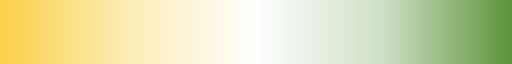

In [3]:
cmap_colors = ['#FBD149', '#FDEDB7', '#FFFFFF', '#CFE0C5', '#5D933B'] 
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', cmap_colors, N=256)
cmap

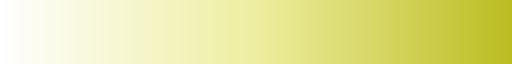

In [4]:
cmap_colors_2 = ['#FFFFFF', '#eeeea0', '#bcbd22'] 
cmap2 = mcolors.LinearSegmentedColormap.from_list('custom_cmap_2', cmap_colors_2, N=256)
cmap2

# Load adata

In [5]:
infer_adata = sc.read_h5ad('../fig4/l1000_mdmt_HDACi.h5ad')
infer_adata.obs["pert_dose_idx"] = infer_adata.obs["pert_dose_idx"].astype("category")
infer_adata.obs["pert_dose_idx_c"] = infer_adata.obs["pert_dose_idx"].astype("float")

infer_adata

AnnData object with n_obs × n_vars = 3439 × 978
    obs: 'sample_id', 'bead_batch', 'nearest_dose', 'pert_dose', 'pert_dose_unit', 'pert_idose', 'pert_time', 'pert_itime', 'pert_time_unit', 'cell_mfc_name', 'pert_mfc_id', 'det_plate', 'det_well', 'rna_plate', 'rna_well', 'count_mean', 'count_cv', 'qc_f_logp', 'qc_iqr', 'qc_slope', 'pert_id', 'pert_type', 'cell_iname', 'qc_pass', 'dyn_range', 'inv_level_10', 'build_name', 'failure_mode', 'project_code', 'cmap_name', 'pert_dose_idx', 'n_replicates', 'pert_idx', 'cell_idx', 'tissue_idx', 'tissue', 'cell_pert_dose_time', 'pretrain_split', 'split_breast_1', 'split_breast_2', 'split_breast_3', 'split_breast_4', 'split_breast_5', 'split_lung_1', 'split_lung_2', 'split_lung_3', 'split_lung_4', 'split_lung_5', 'split_haematopoietic_and_lymphoid_tissue_1', 'split_haematopoietic_and_lymphoid_tissue_2', 'split_haematopoietic_and_lymphoid_tissue_3', 'split_haematopoietic_and_lymphoid_tissue_4', 'split_haematopoietic_and_lymphoid_tissue_5', 'pert_do

# Load predict profiles

In [6]:
predict_result_path = "../fig4/hdaci_predict/"

predict_profile = np.load(predict_result_path+'y_pred.npy')
infer_adata.obsm["X_predict"] = predict_profile

infer_adata

AnnData object with n_obs × n_vars = 3439 × 978
    obs: 'sample_id', 'bead_batch', 'nearest_dose', 'pert_dose', 'pert_dose_unit', 'pert_idose', 'pert_time', 'pert_itime', 'pert_time_unit', 'cell_mfc_name', 'pert_mfc_id', 'det_plate', 'det_well', 'rna_plate', 'rna_well', 'count_mean', 'count_cv', 'qc_f_logp', 'qc_iqr', 'qc_slope', 'pert_id', 'pert_type', 'cell_iname', 'qc_pass', 'dyn_range', 'inv_level_10', 'build_name', 'failure_mode', 'project_code', 'cmap_name', 'pert_dose_idx', 'n_replicates', 'pert_idx', 'cell_idx', 'tissue_idx', 'tissue', 'cell_pert_dose_time', 'pretrain_split', 'split_breast_1', 'split_breast_2', 'split_breast_3', 'split_breast_4', 'split_breast_5', 'split_lung_1', 'split_lung_2', 'split_lung_3', 'split_lung_4', 'split_lung_5', 'split_haematopoietic_and_lymphoid_tissue_1', 'split_haematopoietic_and_lymphoid_tissue_2', 'split_haematopoietic_and_lymphoid_tissue_3', 'split_haematopoietic_and_lymphoid_tissue_4', 'split_haematopoietic_and_lymphoid_tissue_5', 'pert_do

# Filtering vorinostat samples

In [7]:
v_adata = infer_adata[(infer_adata.obs.cmap_name=='vorinostat') & (infer_adata.obs.pert_itime=='24 h')]
v_adata = v_adata[v_adata.obs.cell_iname.isin(list(dict(v_adata.obs.cell_iname.value_counts()).keys())[:10])]

v_data_deg_true = v_adata.copy()
v_data_deg_true.X = v_adata.X-v_adata.obsm['X_ctl']

v_data_deg_predict = v_adata.copy()
v_data_deg_predict.X = v_adata.obsm["X_predict"]-v_adata.obsm['X_ctl']

v_data_deg_true

AnnData object with n_obs × n_vars = 86 × 978
    obs: 'sample_id', 'bead_batch', 'nearest_dose', 'pert_dose', 'pert_dose_unit', 'pert_idose', 'pert_time', 'pert_itime', 'pert_time_unit', 'cell_mfc_name', 'pert_mfc_id', 'det_plate', 'det_well', 'rna_plate', 'rna_well', 'count_mean', 'count_cv', 'qc_f_logp', 'qc_iqr', 'qc_slope', 'pert_id', 'pert_type', 'cell_iname', 'qc_pass', 'dyn_range', 'inv_level_10', 'build_name', 'failure_mode', 'project_code', 'cmap_name', 'pert_dose_idx', 'n_replicates', 'pert_idx', 'cell_idx', 'tissue_idx', 'tissue', 'cell_pert_dose_time', 'pretrain_split', 'split_breast_1', 'split_breast_2', 'split_breast_3', 'split_breast_4', 'split_breast_5', 'split_lung_1', 'split_lung_2', 'split_lung_3', 'split_lung_4', 'split_lung_5', 'split_haematopoietic_and_lymphoid_tissue_1', 'split_haematopoietic_and_lymphoid_tissue_2', 'split_haematopoietic_and_lymphoid_tissue_3', 'split_haematopoietic_and_lymphoid_tissue_4', 'split_haematopoietic_and_lymphoid_tissue_5', 'pert_dose

# PLot ground truth

In [8]:
adata = v_data_deg_true.copy()

ranking genes
    finished: added to `.uns['rank_genes_groups_by_dose']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


{'heatmap_ax': <Axes: >, 'groupby_ax': <Axes: ylabel='pert_dose_idx'>}

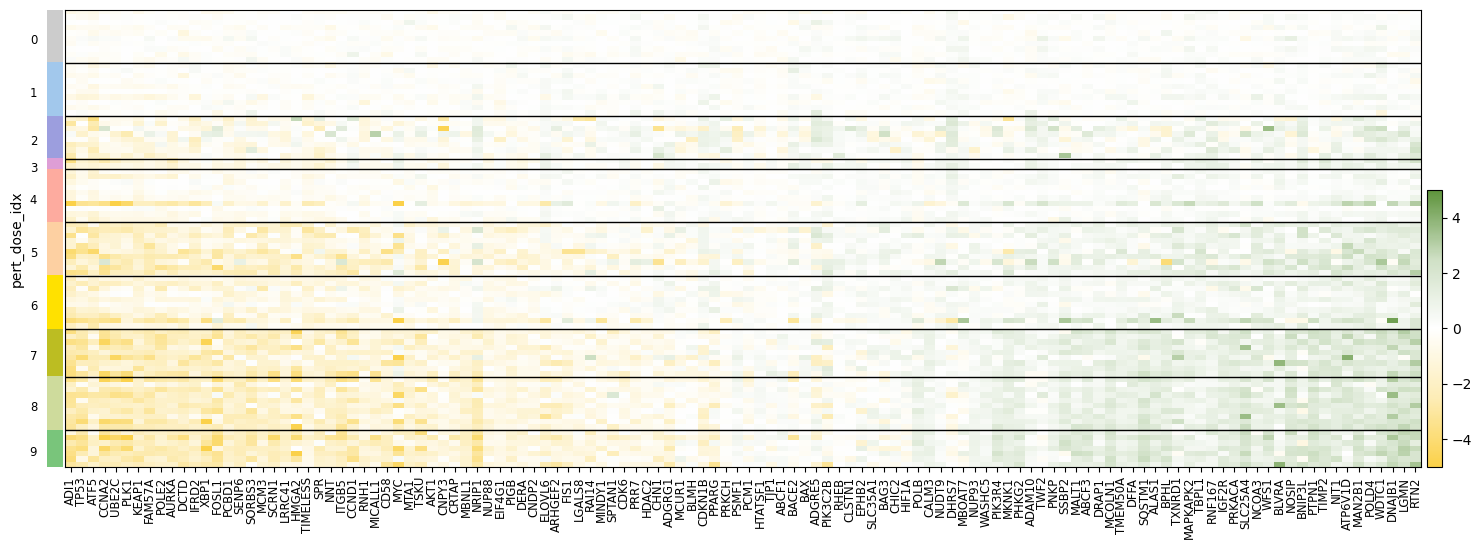

In [9]:
sc.tl.rank_genes_groups(adata, 
                        groupby='pert_dose_idx', 
                        method='t-test', 
                        key_added='rank_genes_groups_by_dose', 
                        add_dendrogram=False,
                        n_genes=15)

genes_arr = adata.uns['rank_genes_groups_by_dose']['names']
genes = [item for sublist in genes_arr for item in list(sublist)]
genes = np.unique(genes)
genes_mean_change = adata[:, genes].X.mean(axis=0) 
sorted_genes = [gene for gene, _ in sorted(zip(genes, genes_mean_change), key=lambda x: x[1])]
adata.uns['pert_dose_idx_colors'] = list(category_colors.values())

sc.pl.heatmap(adata, 
              var_names=sorted_genes,
              groupby='pert_dose_idx',  
              show_gene_labels=True,
              cmap=cmap,
              figsize=(18,6),
              vmin=-5, vmax=5,
             show=False)

# plt.savefig('figs/mdmt_heatmap_vorinostat_ten_celline_truth.svg', format='svg', dpi=300)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


<Axes: title={'center': 'pert_dose_idx_c'}, xlabel='UMAP1', ylabel='UMAP2'>

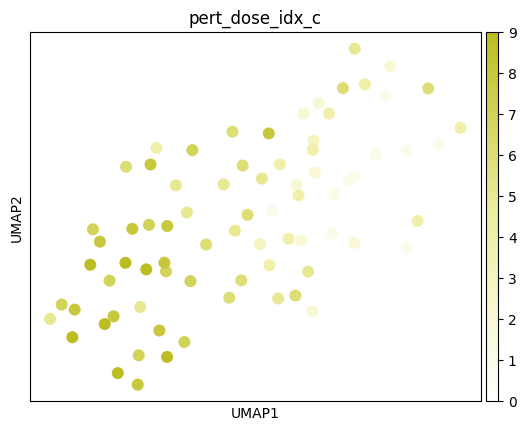

In [10]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)

adata.uns['cell_iname_colors'] = list(category_colors.values())
adata.uns['pert_dose_idx_colors']  = list(category_colors.values())


sc.pl.umap(adata, color=['pert_dose_idx_c'], size=300,
           color_map=cmap2, 
           frameon=True, legend_fontsize=10, wspace=0.3, legend_fontoutline=2,
          show=False)

# plt.savefig('figs/mdmt_umap_vorinostat_ten_celline_truth.svg', format='svg', dpi=300)

# PLot predicted result

In [23]:
adata = v_data_deg_predict.copy()

ranking genes
    finished: added to `.uns['rank_genes_groups_by_dose']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


{'heatmap_ax': <Axes: >, 'groupby_ax': <Axes: ylabel='pert_dose_idx'>}

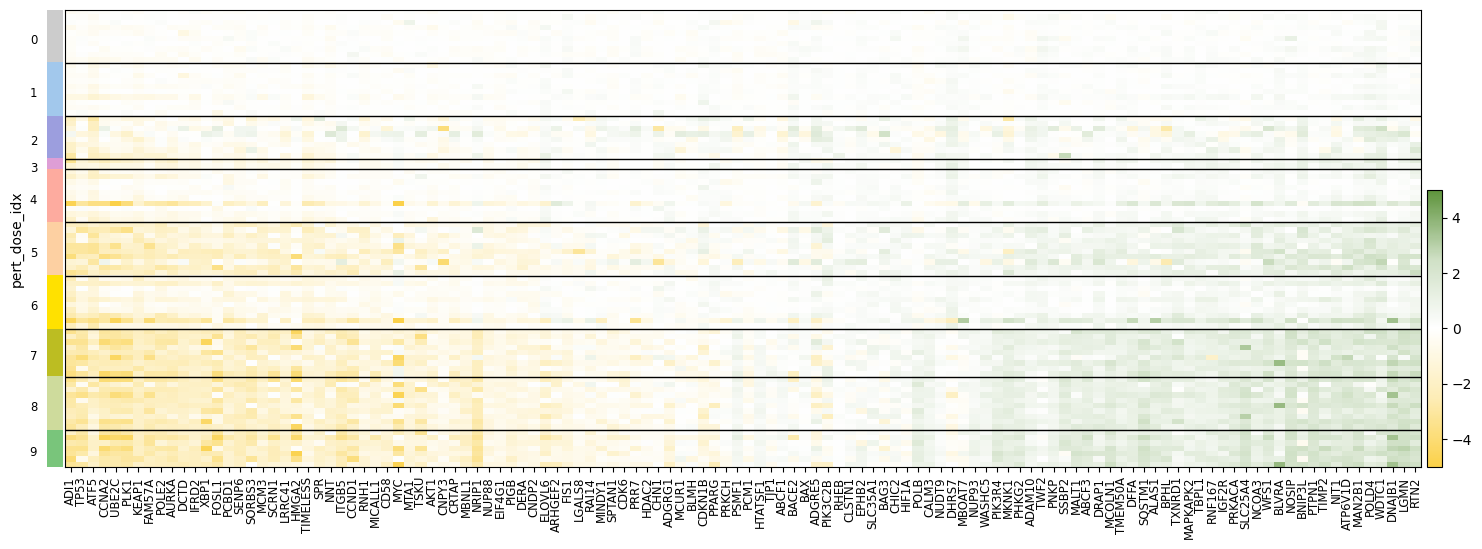

In [24]:
sc.tl.rank_genes_groups(adata, 
                        groupby='pert_dose_idx', 
                        method='t-test', 
                        key_added='rank_genes_groups_by_dose', 
                        add_dendrogram=False,
                        n_genes=15)

adata.uns['pert_dose_idx_colors'] = list(category_colors.values())

sc.pl.heatmap(adata, 
              var_names=sorted_genes,
              groupby='pert_dose_idx',  
              show_gene_labels=True,
              cmap=cmap,
              figsize=(18,6),
              vmin=-5, vmax=5,
             show=False)

# plt.savefig('figs/mdmt_heatmap_vorinostat_ten_celline_predict.svg', format='svg', dpi=300)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


<Axes: title={'center': 'pert_dose_idx_c'}, xlabel='UMAP1', ylabel='UMAP2'>

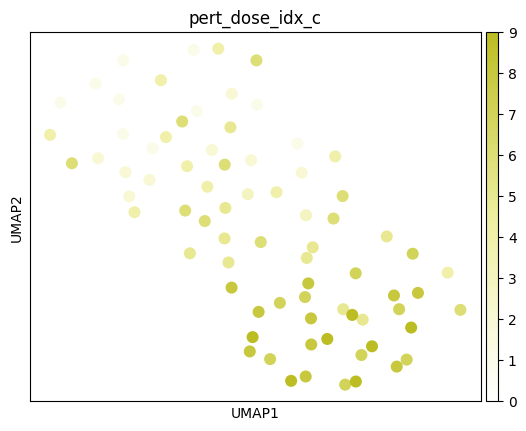

In [25]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=40)
sc.tl.umap(adata)

adata.uns['cell_iname_colors'] = list(category_colors.values())
adata.uns['pert_dose_idx_colors']  = list(category_colors.values())


sc.pl.umap(adata, color=['pert_dose_idx_c'], size=300,
           color_map=cmap2,
           frameon=True, legend_fontsize=10, wspace=0.3, legend_fontoutline=2,
          show=False)


# plt.savefig('figs/mdmt_umap_vorinostat_ten_celline_predict.svg', format='svg', dpi=300)

In [26]:
adata

AnnData object with n_obs × n_vars = 86 × 978
    obs: 'sample_id', 'bead_batch', 'nearest_dose', 'pert_dose', 'pert_dose_unit', 'pert_idose', 'pert_time', 'pert_itime', 'pert_time_unit', 'cell_mfc_name', 'pert_mfc_id', 'det_plate', 'det_well', 'rna_plate', 'rna_well', 'count_mean', 'count_cv', 'qc_f_logp', 'qc_iqr', 'qc_slope', 'pert_id', 'pert_type', 'cell_iname', 'qc_pass', 'dyn_range', 'inv_level_10', 'build_name', 'failure_mode', 'project_code', 'cmap_name', 'pert_dose_idx', 'n_replicates', 'pert_idx', 'cell_idx', 'tissue_idx', 'tissue', 'cell_pert_dose_time', 'pretrain_split', 'split_breast_1', 'split_breast_2', 'split_breast_3', 'split_breast_4', 'split_breast_5', 'split_lung_1', 'split_lung_2', 'split_lung_3', 'split_lung_4', 'split_lung_5', 'split_haematopoietic_and_lymphoid_tissue_1', 'split_haematopoietic_and_lymphoid_tissue_2', 'split_haematopoietic_and_lymphoid_tissue_3', 'split_haematopoietic_and_lymphoid_tissue_4', 'split_haematopoietic_and_lymphoid_tissue_5', 'pert_dose

In [27]:
adata.obsm["X_umap"]

array([[-1.6773409e+00,  2.0667522e+01],
       [-1.5057753e+00,  2.1025730e+01],
       [-2.1722031e-01,  1.9936930e+01],
       [-8.5471815e-01,  2.0214613e+01],
       [ 1.1803863e+00,  1.7852413e+01],
       [-4.0027574e-02,  1.9622704e+01],
       [ 2.3785098e+00,  1.6526209e+01],
       [ 2.3068237e+00,  1.6820030e+01],
       [ 2.5454941e+00,  1.6132616e+01],
       [-7.5760192e-01,  2.1025139e+01],
       [-1.4488573e+00,  2.0281773e+01],
       [ 3.2640514e-01,  1.9719286e+01],
       [ 2.8037310e-01,  1.8990116e+01],
       [-2.8133571e-01,  1.9150312e+01],
       [ 1.8732347e+00,  1.6301353e+01],
       [ 4.5929196e-01,  1.7964115e+01],
       [ 2.4831243e+00,  1.5446443e+01],
       [ 2.3454671e+00,  1.5296429e+01],
       [ 2.0023918e+00,  1.5731685e+01],
       [-1.0805652e+00,  2.1980026e+01],
       [-1.4492235e+00,  2.1854950e+01],
       [ 5.7356644e-02,  2.1142918e+01],
       [-9.2472154e-01,  2.1433163e+01],
       [ 3.9112221e-02,  2.0423264e+01],
       [-6.30041

In [21]:
heatmap_df = pd.DataFrame(v_data_deg_predict[:, sorted_genes].X, index=v_data_deg_predict.obs.pert_dose_idx, columns=sorted_genes)
heatmap_df_sorted = heatmap_df.sort_index()
heatmap_df_sorted

,ADI1,TP53,ATF5,CCNA2,UBE2C,PLK1,KEAP1,FAM57A,POLE2,AURKA,...,PTPN1,TIMP2,NIT1,ATP6V1D,MAN2B1,POLD4,WDTC1,DNAJB1,LGMN,RTN2
pert_dose_idx,,,,,,,,,,,,,,,,,,,,,
0,-0.434326,-0.345703,-0.211548,-0.163452,-0.096924,-0.168091,-0.282471,0.082153,0.129273,-0.112182,...,-0.016266,-0.088501,0.163940,0.087890,0.064575,0.049072,0.087280,-0.018418,-0.093933,0.095703
0,-0.139527,-0.162720,-0.437500,-0.068298,-0.046845,0.122254,-0.085449,0.129516,0.079346,-0.034210,...,-0.027115,-0.128296,0.122620,0.016540,0.274170,0.330810,0.165283,0.099060,0.261475,-0.007988
0,0.143188,-0.106811,-0.225586,-0.135132,0.212891,-0.024383,-0.076111,0.040527,0.162476,0.006500,...,-0.164063,-0.068481,-0.027893,-0.303711,0.131103,0.222778,0.549805,0.019501,0.057465,-0.134155
0,-0.601562,-0.162354,-0.447266,-0.484619,-0.262695,-0.430664,-0.383300,-0.167114,-0.070068,-0.348877,...,0.143555,0.271972,0.239013,-0.038025,0.015480,0.040039,0.603516,-0.010773,0.210938,0.243042
0,-0.136597,-0.272949,-0.453125,-0.189209,-0.189820,-0.251953,-0.432129,-0.172119,-0.116455,-0.022751,...,-0.047608,-0.001546,0.334473,0.078064,0.077332,0.472900,0.126343,-0.052490,-0.164917,0.427734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,-2.679687,-2.843750,-1.904297,-1.935547,-2.626953,-2.773437,-2.207031,-3.144532,-1.365234,-1.966797,...,1.842774,0.996094,1.355469,1.383789,1.713867,0.833008,1.301758,2.369140,2.400391,1.474609
9,-3.333984,-3.388672,-1.934571,-4.046875,-3.460937,-3.773437,-1.981445,-2.513672,-2.824219,-2.892578,...,1.786133,2.585937,1.808593,1.515625,2.611329,1.499024,1.829102,2.769531,2.923828,2.464843
9,-3.175781,-2.763672,-1.129883,-3.234375,-2.957031,-2.976563,-2.011719,-2.748047,-1.999023,-2.474609,...,2.248047,1.652343,1.390625,1.889648,1.847657,1.963867,2.425782,2.123047,2.511719,2.099609


In [31]:
umap_df = pd.DataFrame(adata.obsm["X_umap"], index=adata.obs.index, columns=["UMAP1", "UMAP2"])
umap_df.loc[:, "pert_dose_idx"] = adata.obs.pert_dose_idx
umap_df_sorted = umap_df.sort_values(by="pert_dose_idx")
umap_df_sorted

,UMAP1,UMAP2,pert_dose_idx
cell_drug_dose_time,,,
A375:BRD-K81418486:24 h:0,-1.677341,20.667522,0
HT29:BRD-K81418486:24 h:0,-1.420320,20.894848,0
NPC:BRD-K81418486:24 h:0,-2.263547,21.407192,0
HEPG2:BRD-K81418486:24 h:0,-0.228558,21.389223,0
PC3:BRD-K81418486:24 h:0,-0.994853,21.299931,0
...,...,...,...
HA1E:BRD-K81418486:24 h:9,0.346685,15.928069,9
MCF7:BRD-K81418486:24 h:9,1.778276,14.977117,9
HEPG2:BRD-K81418486:24 h:9,1.382301,15.888185,9


In [33]:
# heatmap_df_sorted.to_csv("../fig4/heatmap_df.csv")
# umap_df_sorted.to_csv("../fig4/umap_df.csv")